##Modifications to SMA crossover strategy


1. We normalize the SMA gap by the slow MA (pc_diff = (lead−lag) / lag)
Previously the gap was divided by price. By scaling it to the slow average, the trigger becomes scale-invariant and anchored to the prevailing trend level. That reduces spurious signals when BTC’s absolute price changes dramatically (e.g., $3k → $60k). Practically, we get fewer false positives and a cleaner trend signal—often improving Sharpe and reducing churn.

2. Add a tiny transaction-cost model tied to position changes
We now compute turnover from changes in position and subtract a small bps cost on each flip/entry/exit. This acts as a regularizer: hyper-active (whipsaw) parameter pairs that “won” only on paper are now penalized, nudging selection toward fewer, higher-quality trades. The result typically has better risk-adjusted returns (higher Sharpe), lower drawdowns, and performance that’s more realistic net of frictions.

3. Refine the threshold slider
With the gap normalized by the lag MA, a ~5% deadband is a sensible default and a smaller step lets you probe the sweet spot. The threshold functions like hysteresis: it ignores tiny SMA wiggles that are mostly noise, only switching when the trend difference is meaningful. That cuts flip-flops in ranges, lowers turnover, and stabilizes the equity curve.

4. Reshape the grid and enforce a minimum gap (e.g., lag > lead + 5)
Widening the lag range (e.g., 30–300) ensures the slow MA actually smooths; enforcing a min gap avoids near-duplicate windows (like 20/25) that behave almost identically and overreact to noise. The change improves the bias–variance trade-off: you accept slightly later entries (more bias) in exchange for far less variance from whipsaws—usually a net win for BTC’s choppy regimes.

5. Fix heatmap assignment with .loc[lag, lead] (no chained indexing)
Writing results with .loc (row=lag, col=lead) removes silent alignment bugs and “SettingWithCopy” pitfalls. The heatmap now faithfully reflects each test’s PnL, so the “best” combo we pick is the actual best, not a byproduct of misassigned cells.

6. Add best/worst lead/lag pairs
Code was added to extrapulate the best performing combination of lead and lag for the strategy compared to Buy&Hold. Worst performbing combination was included for reference.

Overall, these modifications lower the trade count and create cleaner entry points. It also results in a more realistic performance by factoring costs. We also see more optimised performance with an improved Sharpe ratio, shallower drawdowns and smoother equity curve .

The result is a significant improvement over the original in terms of performance of the Strategy.
Original: Underperformance vs Buy&Hold: -217.704
Modified: Outperformance vs Buy&Hold: 211.3012
The sharpe ratio of the Modified version also improved from 0.91 to 1.06.


**SMA (Simple Moving Average) crossover strategy**

It is a type of **Trend Following** (momentum) strategy and onsists of a **leading** and a **lagging** simple moving averages.
Leading SMA has a **shorter look-back period** than lagging moving average. Hence, by definition, leading SMA will be more sensitive to most recent price moves; lagging SMA will be slower to react

*  **LONG**: if Leading (short-term) SMA cross above Lagging SMA
*  **SHORT**: if Leading (long-term) SMA cross below Lagging SMA

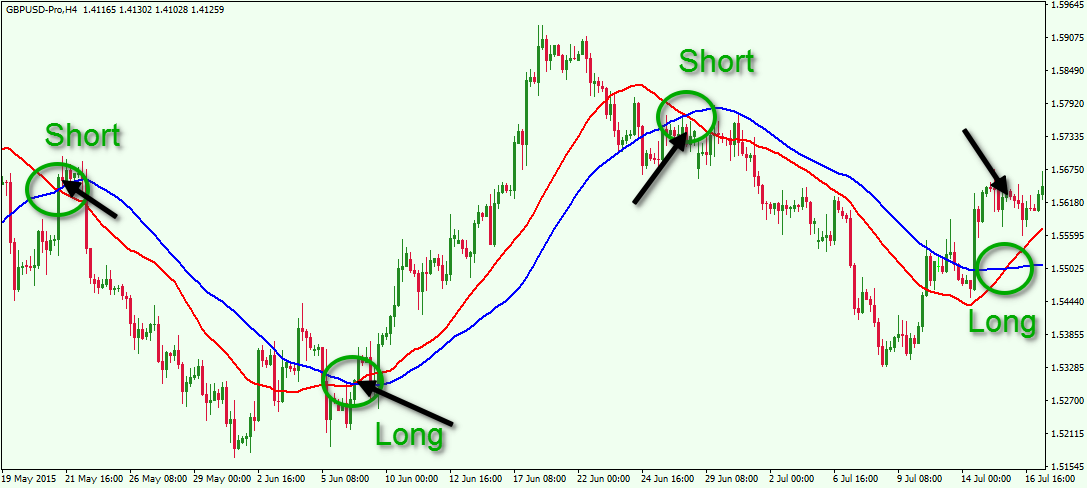


In [ ]:
#@title Execute this block for a temporary yfinance fix
#!pip install yfinance==0.2.61

#import os
#os.kill(os.getpid(), 9)

In [ ]:
#@title Execute this block to start importing the libraries and helper functions

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None


!pip install -q pyfolio-reloaded
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Interative charting
import altair as alt
alt.data_transformers.disable_max_rows()

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()

    # build the lead/lag indicator
    ma_df['lead'] = ma_df['Close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['Close'].rolling(lag).mean()

    # Remove the NaN rows
    ma_df.dropna(inplace = True)

    # calculate the lead and lag difference
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['lag'] # changed close to lag

    # signal column will govern the buying and selling logic as described above;
    # 1 means that we are long, -1 means that we are short and 0 means no position
    ma_df['signal'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['signal'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['signal'])

    # Market column as log returns of price series - which is the simple buy-and-hold performance
    ma_df['Buy-Hold'] = np.log(ma_df['Close'] / ma_df['Close'].shift(1))

    # compute our Strategy returns by multiplying signal (shifted forward to match the Market column

    # Position we can actually trade (no look-ahead)
    ma_df['position'] = ma_df['signal'].shift(1).fillna(0)

    # Turnover in position: 0->1 or 1->0 counts as 1; 1->-1 counts as 2, etc.
    turns = ma_df['position'].diff().abs().fillna(0)

    # Very small friction per change (basis points)
    cost_bps = 5  # tweakable: try 5–15 bps

    # Strategy (log returns) minus a small cost whenever we change position
    ma_df['Strategy'] = ma_df['position'] * ma_df['Buy-Hold'] - turns * (cost_bps/10000.0)

    # perform a cumulative sum operation as well as apply an exponent on Market and Strategy log returns
    # in order to recover the original normalised series
    ma_df[['Buy-Hold','Strategy']] = ma_df[['Buy-Hold','Strategy']].cumsum().apply(np.exp)
    return ma_df


import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plot the OHLCV chart
def ohlcv(df, date, open, high, low, close, volume):
	rDf = df.reset_index()

	# Create subplots and mention plot grid size
	fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
				   vertical_spacing=0.03,
				   subplot_titles=('OHLC', 'Volume'),
				   row_width=[0.2, 0.7])

	fig.add_trace(go.Ohlc(x=rDf[date],
					  open=rDf[open],
					  high=rDf[high],
					  low=rDf[low],
					  close=rDf[close],
					  name="OHLC"),
					  row=1, col=1)

	# Bar trace for volumes on 2nd row without legend
	fig.add_trace(go.Bar(x=rDf[date], y=rDf[volume], showlegend=False), row=2, col=1)

	# Do not show OHLC's rangeslider plot
	fig.update(layout_xaxis_rangeslider_visible=False)

	fig.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
#@title 1: Download historical daily data from Yahoo Finance

ticker = 'BTC-USD' # @param ["BTC-USD", "ETH-USD", "NVDA", "0700.HK", "2628.HK", "0941.HK", "0939.HK", "GC=F"] {allow-input: true}
startDate = '2010-01-01' #@param {type:"date"}

stock = yf.Ticker(ticker)

# get stocks daily data OHLCV (Open/High/Low/Close/Volume) from Yahoo Finance
df= stock.history(start=startDate)
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'

''' In case Yahoo finance doesn't work, download from github
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/bitcoinHistorical.csv'
df = pd.read_csv(url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
'''

df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save the dataframe to csv for downloading
df.to_csv('historical.csv')

#2: Visualize and understand the data (Exploratory Data Analysis)
Plot OHLCV (Open/High/Low/Close/Volume) candle sticks

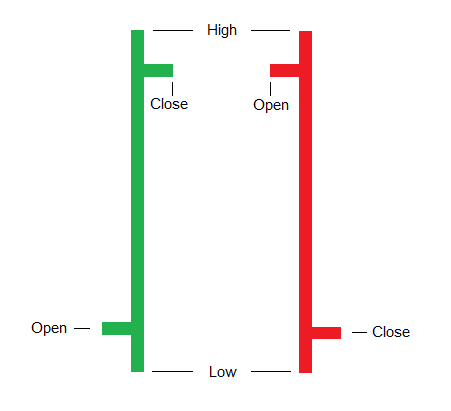

In [ ]:
# Filter the start date
#df = df.loc['2020-01-01':]

ohlcv(df, 'Date', 'Open', 'High', 'Low', 'Close', 'Volume')

count    3992.000000
mean        0.002019
std         0.035560
min        -0.371695
25%        -0.012409
50%         0.001275
75%         0.016339
max         0.252472
Name: Close, dtype: float64


<Axes: >

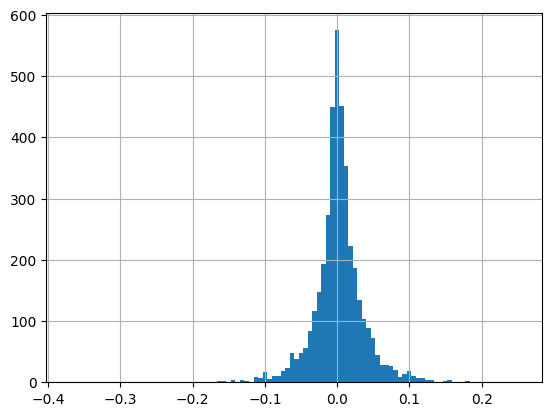

In [ ]:
# look at price volatility (closing price change) summary statistics
print(df['Close'].pct_change().describe())
df['Close'].pct_change().hist(bins=100)

In [ ]:
lead = 45 # short-term moving average days
lag = 125 # long-term moving average days

df['lead'] = df['Close'].rolling(lead).mean()
df['lag'] = df['Close'].rolling(lag).mean()

COLUMNS = ['Close', 'lead', 'lag']
df[COLUMNS]

Close           lead            lag
Date                                                                  
2014-09-17 00:00:00+00:00     457.334015            NaN            NaN
2014-09-18 00:00:00+00:00     424.440002            NaN            NaN
2014-09-19 00:00:00+00:00     394.795990            NaN            NaN
2014-09-20 00:00:00+00:00     408.903992            NaN            NaN
2014-09-21 00:00:00+00:00     398.821014            NaN            NaN
...                                  ...            ...            ...
2025-08-18 00:00:00+00:00  116252.312500  116611.604167  107410.515563
2025-08-19 00:00:00+00:00  112831.179688  116713.826389  107640.894062
2025-08-20 00:00:00+00:00  114274.742188  116825.885764  107875.926000
2025-08-21 00:00:00+00:00  112419.031250  116917.423090  108099.671813
2025-08-22 00:00:00+00:00  113199.507812  117011.850521  108324.760562

[3993 rows x 3 columns]

In [ ]:
#@title Plot the SMA cross over
# Rearrange the data into altair format
# altair plots interactive charts with zooming and panning
plot_data = df[COLUMNS].reset_index().melt('Date')

alt.Chart(plot_data).mark_line().encode(
  x='Date:T',
  y='value',
  color='variable'
).properties(
  width=800,
  height=600
).interactive()

alt.Chart(...)

#3: Back testing the strategy with the historical data

Strategy Signal: (1, -1, 0)

*   **1 LONG**: if Leading SMA is above Lagging SMA by the threshold -> hold 1 long position of bitcoin
*   **-1 SHORT**: if Leading SMA is below Lagging SMA by the threshold -> short 1 bitcoin
*   **0 FLAT**: if the difference of Leading and Lagging SMA is less than the threshold -> flatten the bitcoin position


Back testing parameters
*   **lead**: short-term moving average days
*   **lag**: long-term moving average days
*   **threshold**: sensitivity of the strategy and is used to filter out weak signals. **Smaller the number means more sensitive** to the signals (which usually means more long/short positions)

In [ ]:
#@title Run back testing with different parameters

lead = 45 #@param {type:"integer"}
lag = 125 #@param {type:"integer"}
threshold = 0.05 #@param {type:"slider", min:0, max:0.2, step:0.005}

ma_df = test_ma(df, lead, lag, threshold).dropna()

SMA_COLUMNS = ['Close', 'lead', 'lag', 'lead-lag', 'pc_diff', 'signal', 'Buy-Hold', 'Strategy']
ma_df[SMA_COLUMNS]

Output hidden; open in https://colab.research.google.com to view.

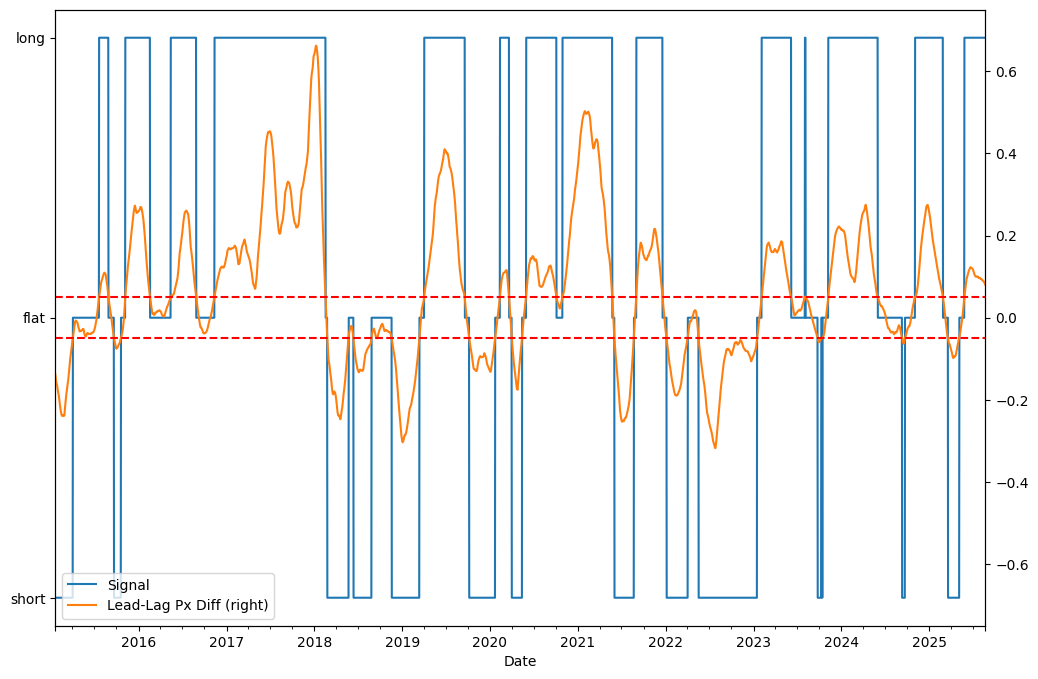

In [ ]:
#@title Plot the back test result
# Plot signal over "lead-lag" price difference (align at 0)
# Plot signal as the left y-axis
ax1 = ma_df.signal.plot(label='Signal', legend=True, figsize=(SCREEN_X, SCREEN_Y))
ax1.set_ylim(-1.1, 1.1)
plt.yticks([-1, 0, 1], ['short', 'flat', 'long'])

# Plot "lead-lag" price difference as the right y-axis
ax2 = ma_df.pc_diff.plot(secondary_y=True, label='Lead-Lag Px Diff', legend=True, figsize=(SCREEN_X, SCREEN_Y))
SAFE_MARGIN = 0.05
ylimit = max(round(ma_df.pc_diff.max(), 1), - round(ma_df.pc_diff.min(), 1)) + SAFE_MARGIN
ax2.set_ylim(-ylimit, ylimit)

plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')

### Compare Buy-hold vs SMA Strategy performance

buy_and_hold strategy which benefit from soaring bitcoin price
Strategy: SMA crossover long/short which can benefit from both soaring and dropping bit coin price (provided that the SMA predicted the price movement correctly)

Buy-Hold    526.849972
Strategy     93.844582
Name: 2025-08-22 00:00:00+00:00, dtype: float64


<Axes: xlabel='Date'>

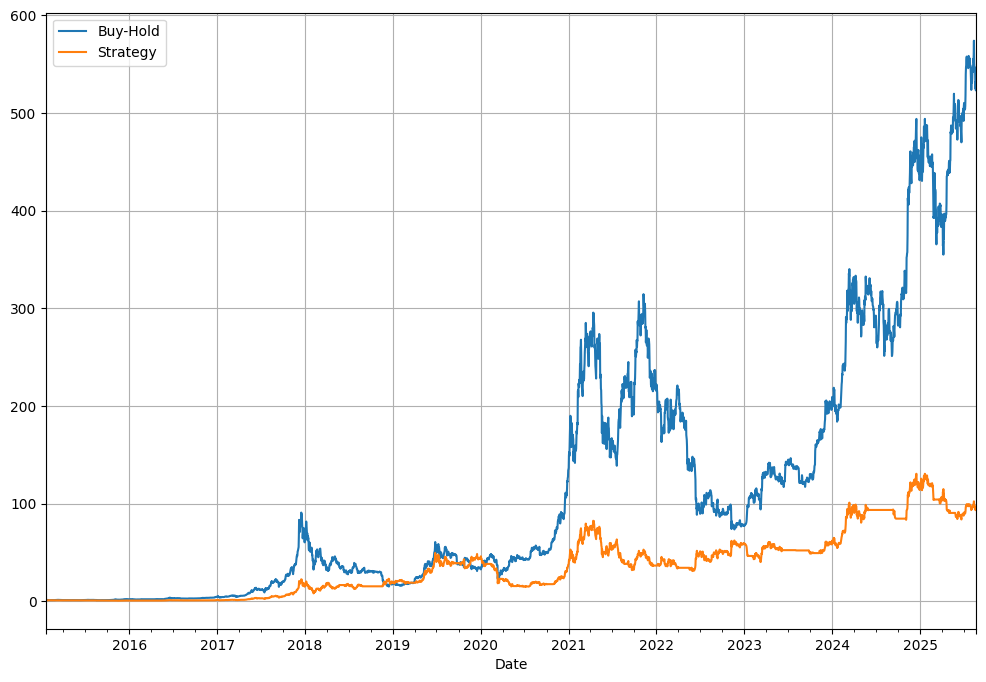

In [ ]:
#@title Plot Buy-Hold vs SMA Strategy performance

print(ma_df[['Buy-Hold', 'Strategy']].iloc[-1])
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)

#4. Backtest the strategy with different combination to find the optimal lead/lag params

In [ ]:
# start, end, step
# Short MA values (fast)
leads = np.arange(5, 105, 5)

# Long MA values (slow) – start slower and go wider
lags = np.arange(30, 305, 5)

# Require a true "slow" MA: avoid noisy near-equal windows
lead_lags = [(lead, lag) for lead in leads for lag in lags if lag > lead + 5]

pnls = pd.DataFrame(index=lags, columns=leads)

In [ ]:
# Run the strategy with the different combination of lead/lag params
# Calculate the different between market Buy-Hold and strategy performance as PnL
for lead, lag in lead_lags:
  ma_df = test_ma(df, lead, lag, threshold)
  perf = ma_df['Strategy'].iloc[-1] - ma_df['Buy-Hold'].iloc[-1]
  pnls.loc[lag, lead] = float(perf)   # correct orientation + no chained indexing
  print(lead, lag, perf)

pnls

5 30 -266.90160526262406
5 35 -189.6405487803931
5 40 -145.03086898314464
5 45 -206.62001015634766
5 50 -181.05758713859947
5 55 -231.8920024254188
5 60 -81.16283367564802
5 65 -54.47617076423836
5 70 -151.02629719553724
5 75 -81.5525178857612
5 80 13.72255995061397
5 85 152.32101428133245
5 90 46.94700327597087
5 95 -125.07630669753999
5 100 -151.378684388904
5 105 3.4506049218647377
5 110 206.8088430931715
5 115 73.71915776655436
5 120 -347.81380702800107
5 125 -245.83153309186747
5 130 -108.43910527190917
5 135 -154.7428012707348
5 140 -240.2908223425526
5 145 -387.7745534966974
5 150 -340.1530186953462
5 155 -313.42925210002204
5 160 -338.08087269567454
5 165 -224.18385316281294
5 170 -96.9324452661728
5 175 -37.70266161070657
5 180 -160.12268305972734
5 185 -204.6669861878587
5 190 -78.07589878917628
5 195 -128.46510929085923
5 200 -82.37662854123414
5 205 -170.55310355160935
5 210 -228.7199435049052
5 215 -289.8985112081151
5 220 -296.55114162050126
5 225 -332.6163764699853
5 230

5           10          15          20          25          30   \
30  -266.901605  -266.06879 -280.131097 -293.866518         NaN         NaN   
35  -189.640549 -188.771078 -243.291888 -284.896047 -290.384369         NaN   
40  -145.030869 -166.406487 -234.174256 -267.818738 -302.412303 -317.052907   
45   -206.62001  -82.792525 -203.173879 -165.254856 -289.297497 -320.886227   
50  -181.057587 -157.646829  -71.670696 -247.584757 -286.742252 -310.514453   
55  -231.892002 -147.748126 -130.424522 -271.347457 -271.429478 -293.605166   
60   -81.162834 -170.195573 -173.024774 -258.544954 -256.905027 -272.445008   
65   -54.476171 -191.269404  -88.949035 -260.012031 -269.992489 -297.849437   
70  -151.026297 -200.678192 -193.303732 -245.773891 -225.383289  -283.22631   
75   -81.552518 -191.316963 -246.451874 -220.112768 -258.178187 -278.824874   
80     13.72256 -167.790512 -210.899857 -202.229991 -227.318923 -261.987148   
85   152.321014 -176.258181 -122.727398 -142.176231 -238.871874 -278.246442   
90    46.947003 -138.004863 -132.462819 -132.023212 -253.763734  -270.04065   
95  -125.076307  -74.276814 -109.934396 -188.330743 -284.608511 -305.522285   
100 -151.378684   -2.277619 -217.772189 -255.080813  -316.14835 -321.162926   
105    3.450605  -13.128835 -157.301787 -293.081583 -331.596484 -334.031038   
110  206.808843 -152.690252  -318.01711 -381.025138 -371.433453 -373.698023   
115   73.719158  -57.596346 -284.342665 -316.562168 -254.656536 -330.792957   
120 -347.813807 -398.594672 -535.996217 -573.878132  -585.95299  -589.06908   
125 -245.831533 -318.738411 -342.140804 -438.932455 -471.255844  -482.16828   
130 -108.439105 -195.687094  -284.55763  -364.06083 -363.428939 -379.130759   
135 -154.742801 -242.926623 -376.850867  -398.44868 -387.423516  -392.27267   
140 -240.290822 -312.066262 -396.636065 -397.653607 -382.169633 -389.602607   
145 -387.774553 -439.832827 -387.871855  -435.94477 -438.403685 -395.226385   
150 -340.153019 -404.584564 -396.089592  -412.93725 -405.724608 -350.294131   
155 -313.429252 -367.832192 -382.697417 -393.581955 -361.489024 -301.489041   
160 -338.080873 -389.165894 -385.994348 -394.261838 -302.814202 -307.439325   
165 -224.183853 -320.372237 -332.066578 -354.357938 -229.482608 -296.311077   
170  -96.932445 -259.568186 -242.372367 -272.833411 -241.577859 -263.229278   
175  -37.702662 -183.820179 -152.609873  -59.416318 -267.595898 -225.227386   
180 -160.122683 -160.912238  -203.85737  -82.458956 -303.091934 -288.458674   
185 -204.666986 -176.464606 -248.745098 -231.757677 -347.123642  -337.26847   
190  -78.075899 -270.070563 -292.676463 -314.570497   -396.2473 -362.329829   
195 -128.465109 -306.680236 -290.578916 -302.089038 -331.021294  -328.78641   
200  -82.376629 -321.079081 -292.688828 -320.873574 -314.272685 -327.623684   
205 -170.553104 -332.689386  -255.67458 -372.492335 -370.836164 -374.223805   
210 -228.719944 -392.238307 -364.058159 -396.453296 -407.203981  -457.26741   
215 -289.898511 -392.893222 -388.129053 -371.498864 -366.266235 -411.164739   
220 -296.551142 -388.463723 -345.069554 -319.267994 -384.806689 -403.671145   
225 -332.616376 -392.204692 -347.267603 -363.560185 -393.242013 -423.942512   
230 -258.214911 -365.128669  -346.22364 -298.962585 -348.450653 -418.294617   
235 -326.122597 -387.036198 -347.229869 -250.208115 -314.824816  -402.12451   
240 -333.025368 -361.522934 -365.117759 -343.374927 -380.662055 -434.855866   
245 -332.617406 -269.028787 -349.608075 -381.353729 -426.511399 -443.315527   
250  -351.00842 -201.785937  -194.80977 -386.693308 -424.573396 -403.865904   
255 -369.829863 -226.175712 -230.226597 -417.499631  -428.62862 -412.921468   
260 -386.659339 -329.150329 -352.635309 -443.581088 -429.254793   -426.7655   
265 -343.465094 -342.415327 -288.295049 -416.232919 -432.768106  -427.92351   
270 -320.318591 -316.887612 -291.710559 -406.102392 -407.520084 -391.087288   
275 -314.910789 -274.783722 -301.413035  -400.36202 -341.71969

<Axes: >

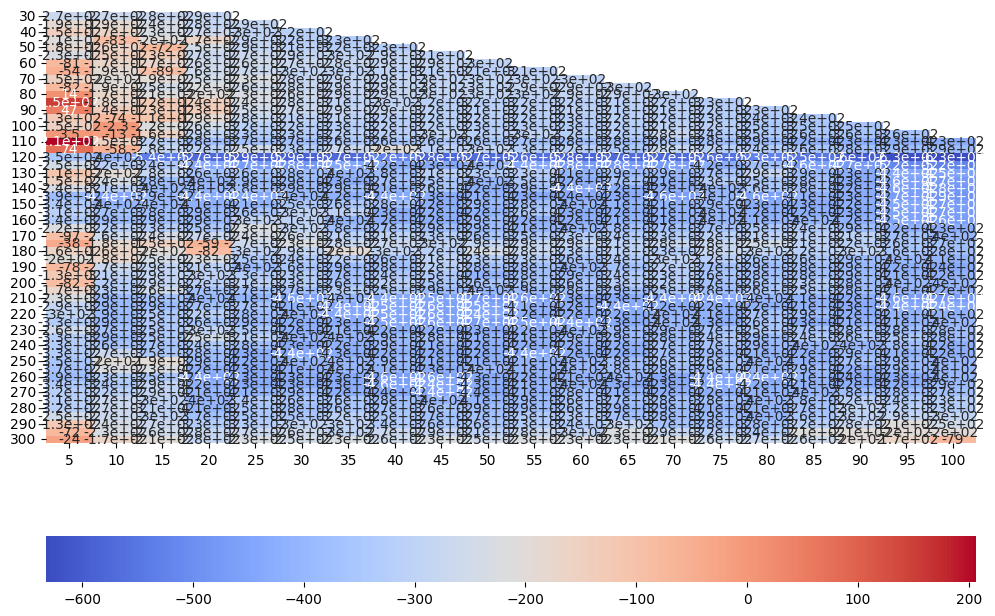

In [ ]:
# Use Heatmap to visualize the backtest results
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (SCREEN_X, SCREEN_Y))
sns.heatmap(PNLs, cmap='coolwarm', annot=True, cbar_kws={'orientation': 'horizontal'})

In [ ]:
# best lead/lag from existing grid (lags are rows, leads are columns)

# this code prints the best combination of lead and lag and compares performance against Buy&Hold

best_pair = pnls.astype(float).stack().idxmax()   # (lag, lead) due to your pnls index/columns
best_value = pnls.astype(float).stack().max()
# flip to (lead, lag) for readability
best_lead_lag = (best_pair[1], best_pair[0])
print("Best (lead, lag):", best_lead_lag, "   Outperformance vs Buy&Hold:", round(best_value, 4))

Best (lead, lag): (np.int64(5), np.int64(110))    Outperformance vs Buy&Hold: 206.8088


In [ ]:
# worst lead/lag from existing grid (lags are rows, leads are columns)

# this code prints the worst combination of lead and lag and compares performance against Buy&Hold

worst_pair = pnls.astype(float).stack().idxmin()
worst_lead_lag = (worst_pair[1], worst_pair[0])
print("Worst (lead, lag):", worst_lead_lag, "   Underperformance vs Buy&Hold:", round(pnls.astype(float).stack().min(), 4))

Worst (lead, lag): (np.int64(100), np.int64(120))    Underperformance vs Buy&Hold: -632.5394


Buy-Hold    428.469519
Strategy    635.278362
Name: 2025-08-22 00:00:00+00:00, dtype: float64

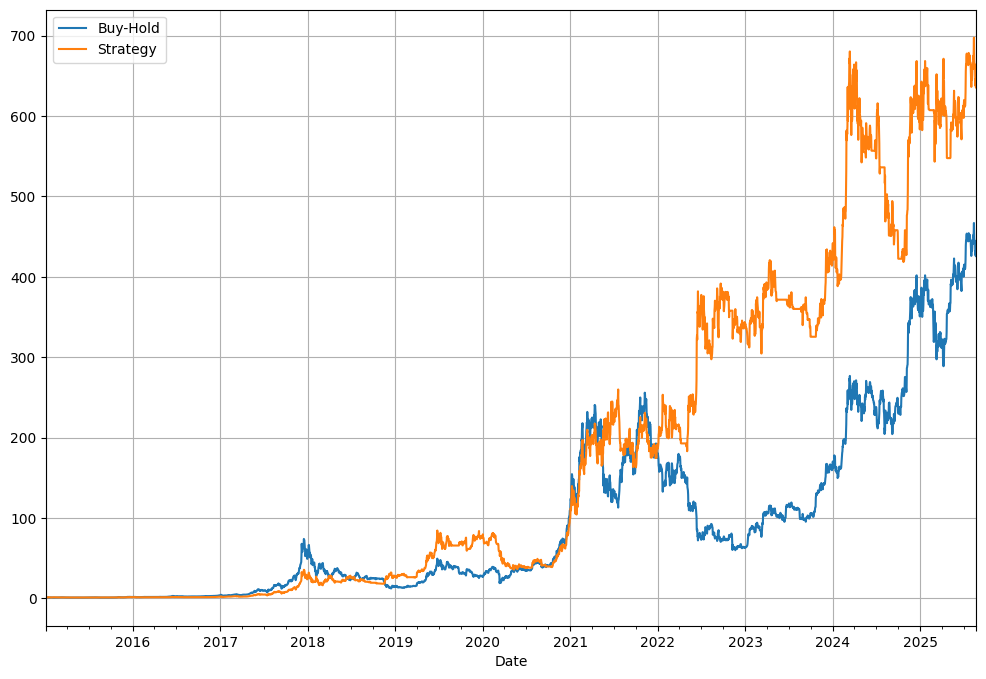

In [ ]:
# Run again with the best lead/lag SMA combinations
lead = 5 # heatmap shows best lead value is 5 (unchanged)
lag = 110 # heatmap shows best lag value is 110 (changed from 105)

ma_df = test_ma(df, lead, lag, threshold).dropna()
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)
ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

#5. Show the performance details of SMA strategy

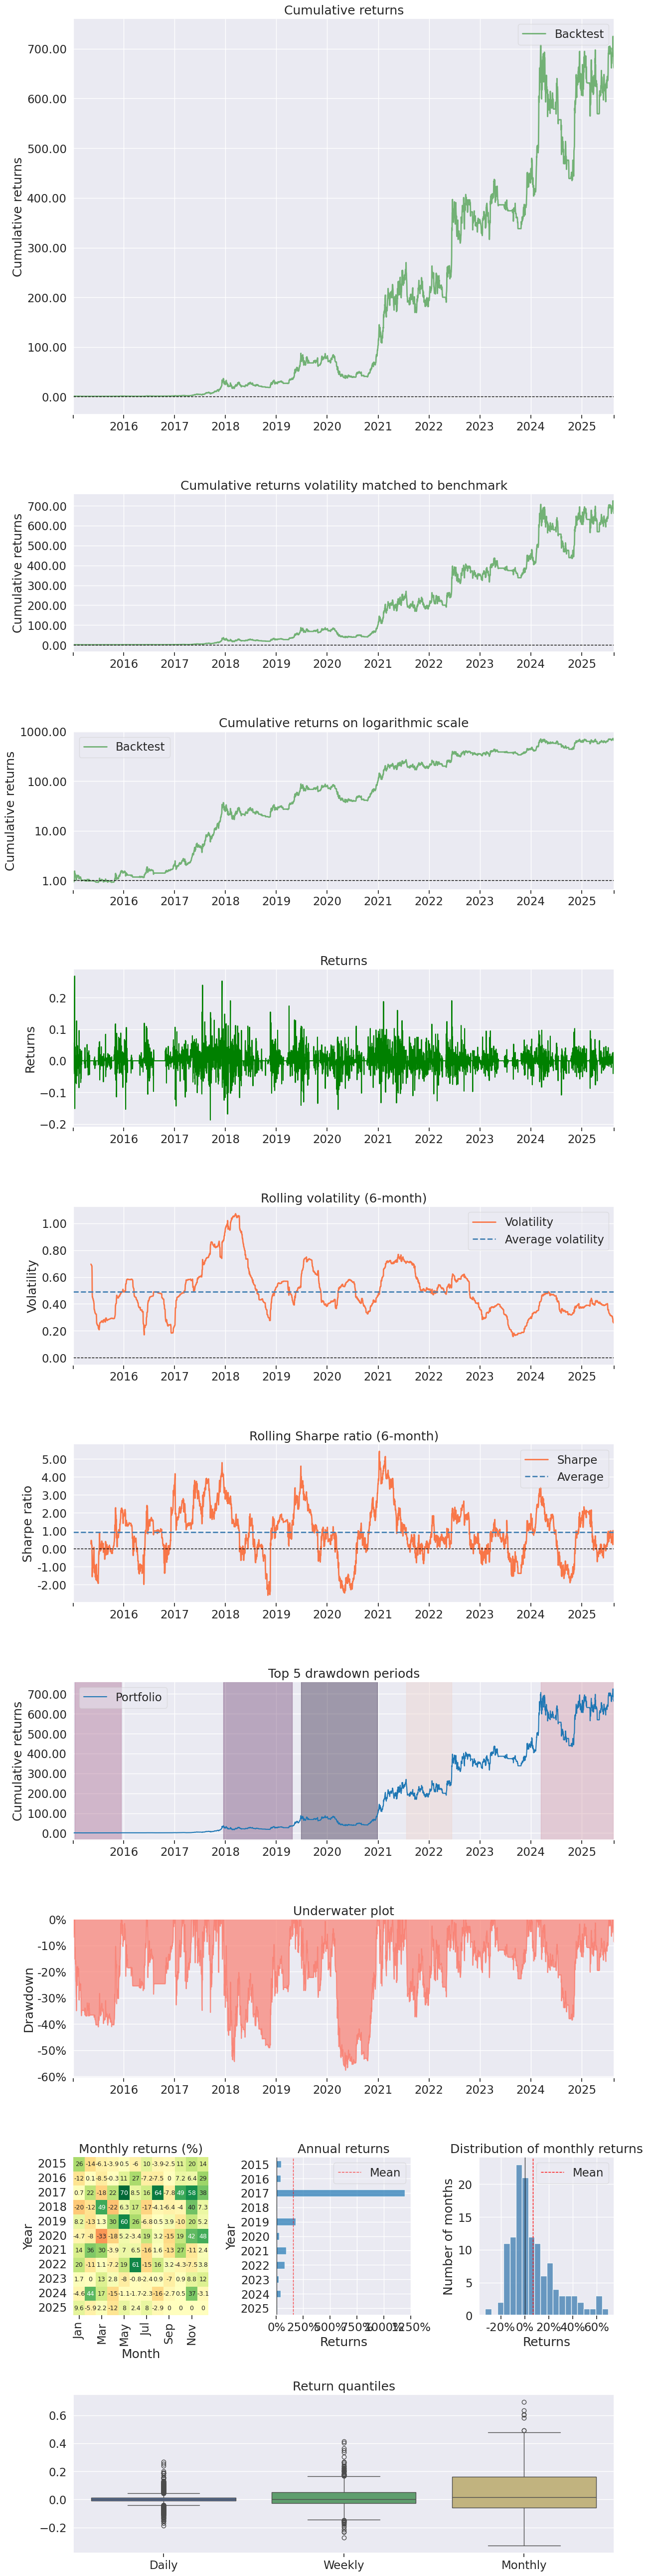

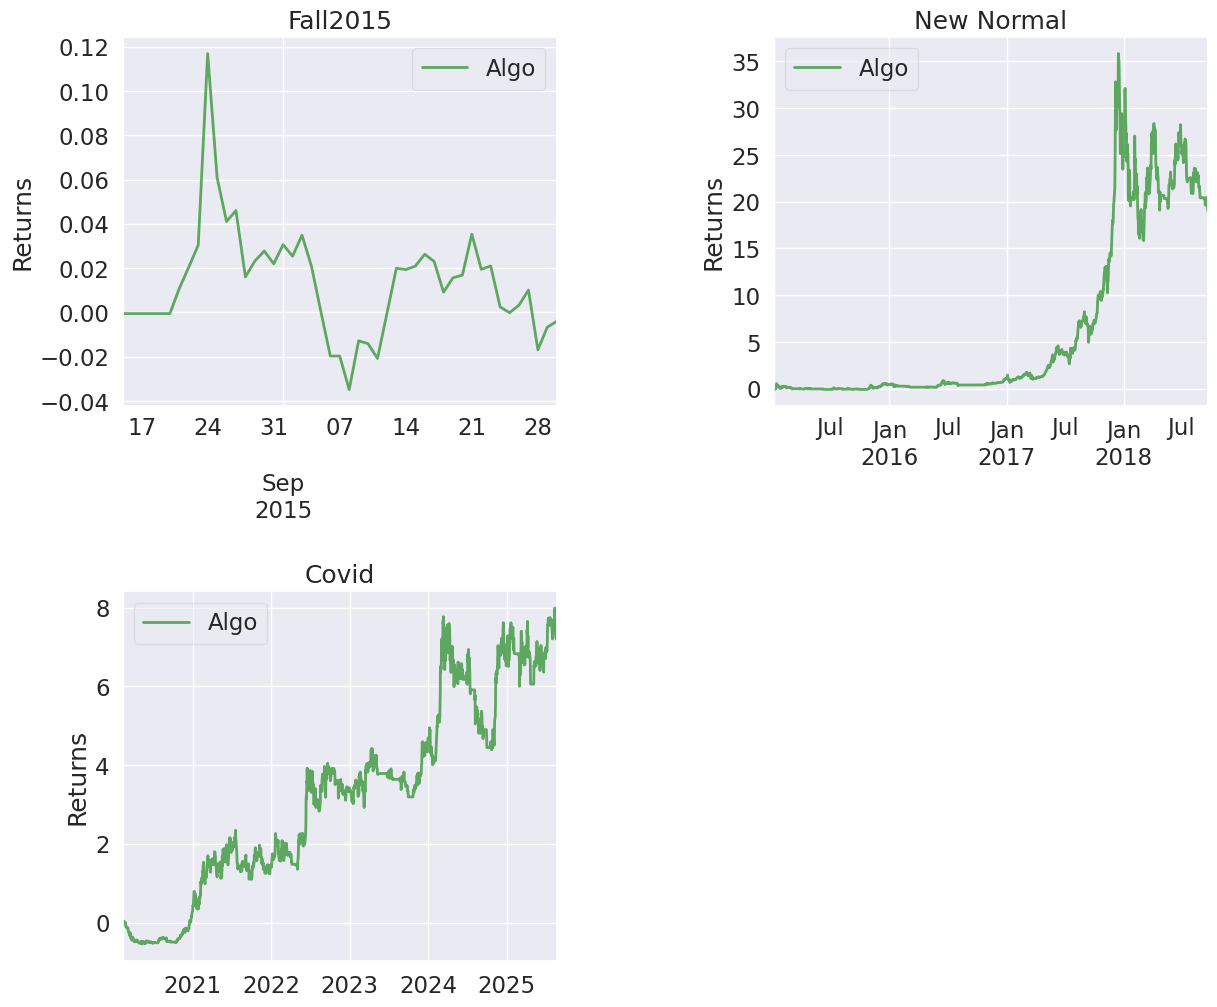

In [ ]:
pf.create_full_tear_sheet(ma_df['Strategy'].pct_change())

**Suggestions**

1. Backtest with different **threshold** values
2. Separate the data into 2 portions (**research & back-test**). Optimize the lead/lag/threshold params from the research portion and use back-test data to measure the strategy performance
3. Try different Technical Analysis signals such as **RSI, Bollinger Bands** with TA-Lib (https://pypi.org/project/TA-Lib/)
4. Try other cryptos (e.g. ETH-USD) or stocks (e.g. 0005.HK)
5. Try different data source: https://colab.research.google.com/github/kenwkliu/ideas/blob/master/colab/DataSource.ipynb
